## Lesson 14: 
### Exercise: Fun with Gamma Ray Bursts
---

In [365]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, estimate_bandwidth
from sklearn.neighbors import KernelDensity
import pandas as pd
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (5, 4)

In [366]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


Since the dataset is multidimensional, the first thing we can do to analyze it is to perform some simple dimensionality reduction, through the **PCA** *scikit.learn* method. 

First we can limit ourselves only to the columns related to measurements of relevant physical quantities:

**NB**: We exclude the *redshift* column since most of the redshift values are *NaN* as we can see in the following cell.

In [367]:
redshift = data[11,:]
nans = redshift[redshift=='-999']
len(nans), len(redshift)

(7830, 8441)

---

In [368]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

We can use the following columns:

- **ra**
- **decl**
- **T90**
- **fluence**
- **T100**


In [369]:
X = data[[3,4,6,9,12], :].T
names_X = names[[3,4,6,9,12]]

In [370]:
df = pd.DataFrame(X, columns=names_X)

In [371]:
mask = (df == '-999').any(axis=1)
print(np.sum(mask)) #Not too many NaNs now.
df_cleaned = df[~mask]
df_cleaned = df_cleaned.apply(pd.to_numeric)
df_cleaned

1150


,ra,decl,T90,fluence,'T100'
1,83.5500,37.7700,65.024,1.711600e-06,65.024
2,128.1539,-14.4374,24.832,1.176600e-05,25.348
3,307.5700,-15.4300,9.728,7.982900e-07,9.728
4,203.7000,-13.2300,21.760,1.598800e-06,21.760
5,280.3700,44.5400,0.640,1.782600e-07,0.640
...,...,...,...,...,...
8436,335.9500,25.7667,430.016,1.351000e-06,430.016
8437,91.3000,-22.7667,90.176,1.327700e-05,94.400
8438,201.3000,-45.4167,3.136,2.485800e-08,3.136
8439,193.4750,-8.3833,208.576,1.651000e-07,208.576


In [372]:
X_data = np.array(df_cleaned.values.tolist())
X_data.shape

(7291, 5)

Let's plot some combinations of the data columns so that we can identify the variables for which we can spot the presence of different populations.

[]

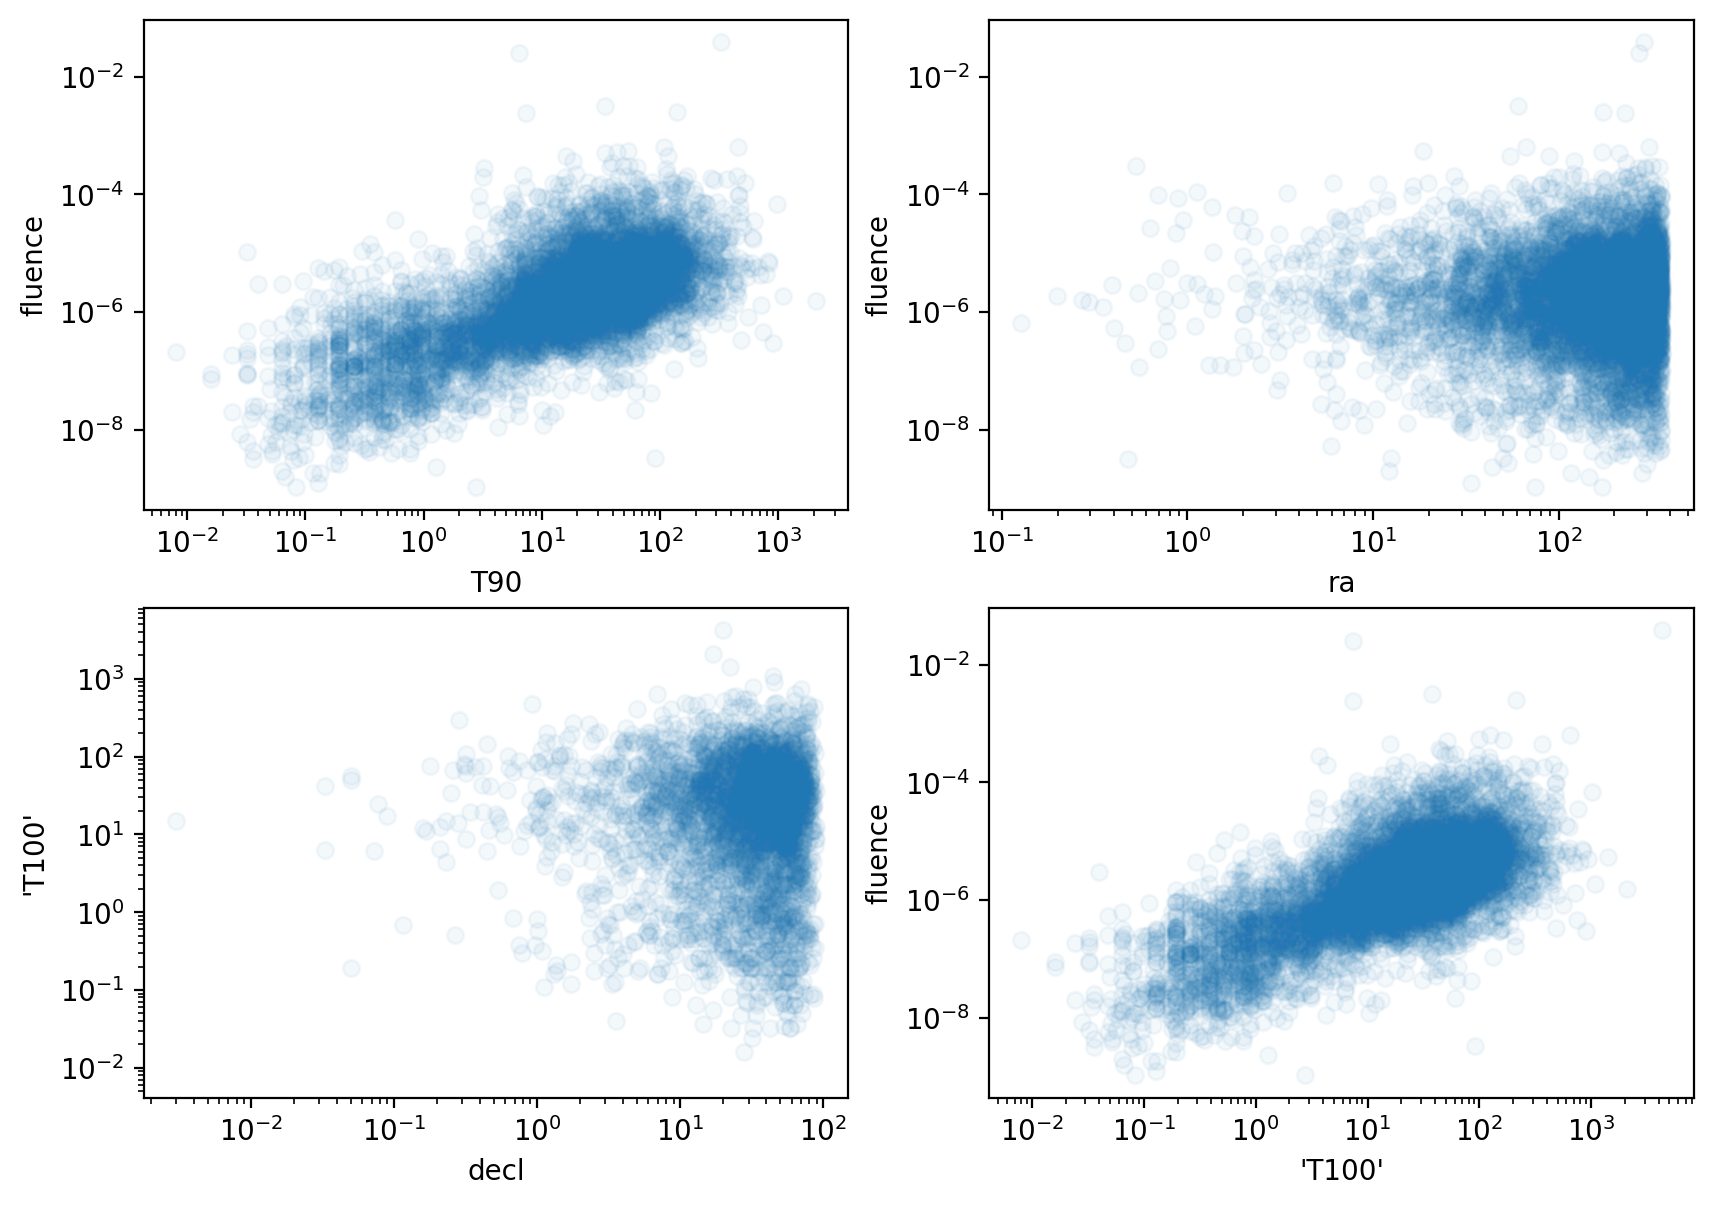

In [373]:
fig, ax = plt.subplots(2,2, figsize=(10,7))

plt.subplot(221)
plt.scatter(X_data[:,2], X_data[:,3], alpha=0.05)
plt.xlabel(names_X[2])
plt.ylabel(names_X[3])
plt.loglog()

plt.subplot(222)
plt.scatter(X_data[:,0], X_data[:,3], alpha=0.05)
plt.xlabel(names_X[0])
plt.ylabel(names_X[3])
plt.loglog()

plt.subplot(223)
plt.scatter(X_data[:,1], X_data[:,4], alpha=0.05)
plt.xlabel(names_X[1])
plt.ylabel(names_X[4])
plt.loglog()

plt.subplot(224)
plt.scatter(X_data[:,4], X_data[:,3], alpha=0.05)
plt.xlabel(names_X[4])
plt.ylabel(names_X[3])
plt.loglog()

- It seems that a bimodality in the population of **GRBs** is evident when we plot either *T90* or *T100* against the fluence. This makes some sense because we already know that GRBs can be **short** or **long**, so it's reasonable to expect that the bimodality arises when some sort of measurement of time is involved.

[]

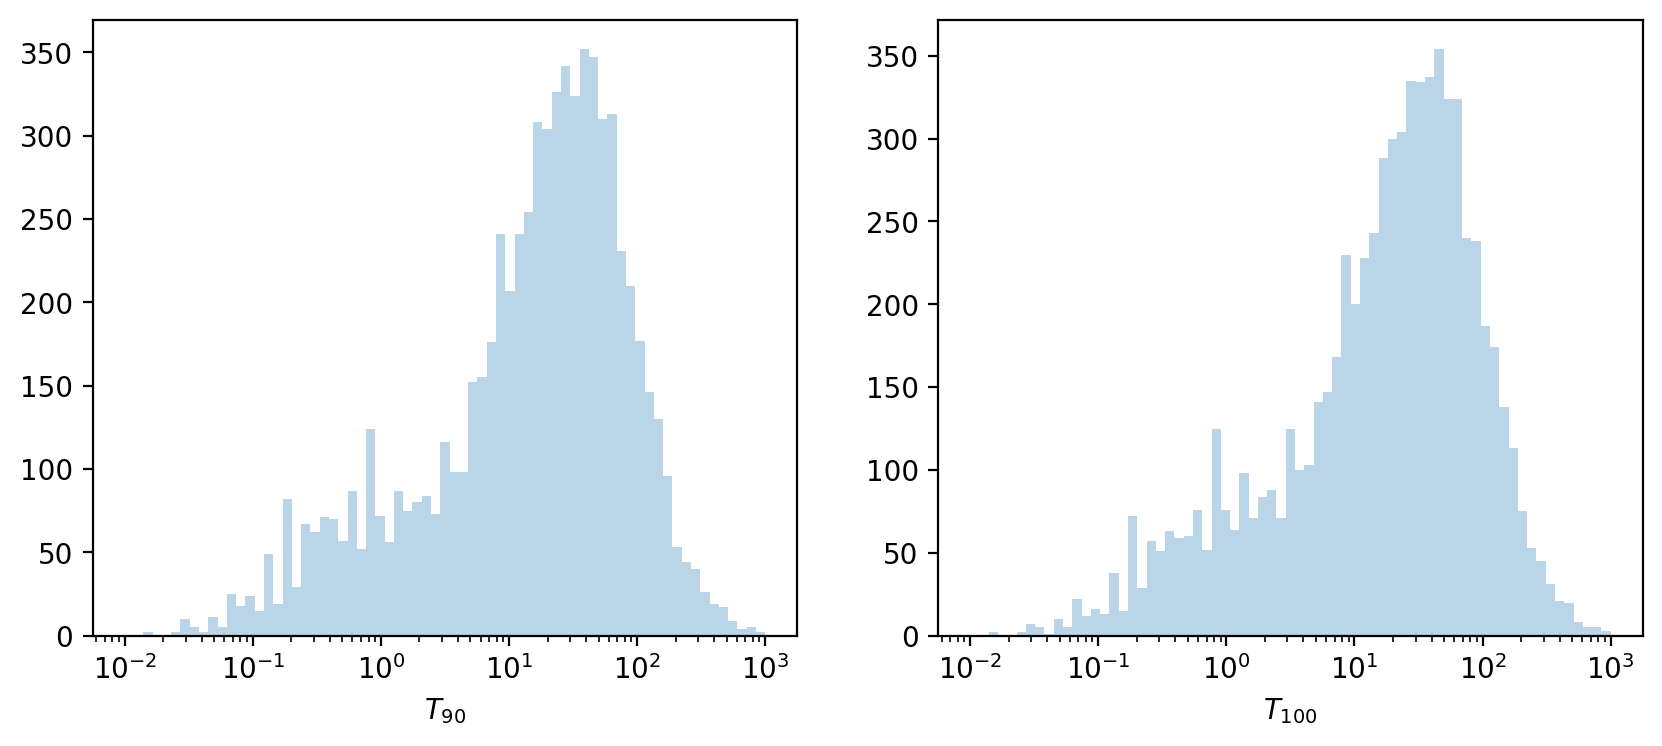

In [374]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

plt.subplot(121)
T90 = df_cleaned["T90"].values
T100 = df_cleaned["'T100'"].values
plt.hist(T90, bins= np.logspace(-2,3,70), alpha=0.3);
plt.semilogx()
plt.xlabel(r'$T_{90}$')
plt.subplot(122)
plt.hist(T100, bins= np.logspace(-2,3,70), alpha=0.3);
plt.xlabel(r'$T_{100}$')
plt.semilogx()

By looking at the distribution of **T90** and **T100**, the presence of two components is quite clear. Let's now apply some clustering methods.

In [375]:
T90, fluence, T100 = X_data[:, 2], X_data[:, 3], X_data[:, 4] #We select the columns T90, T100 and fluence.

We may want to apply ML methods to perform clustering of the data into two groups.
- First we will apply the **KMeans** method to split the data into two groups
- Then we'll make use of the **GaussianMixture** algorithm to to make sure we get similar results with different algorithms.

### KMeans

In [376]:
X = np.array([np.log(T90), np.log(fluence)]).T
clf = KMeans(n_clusters=2, n_init=10) #Try 2 clusters to start with

#Error if any element of X is -inf (meaning that the original array contained a 0): Let's mask those.
mask = ~np.isinf(X).any(axis=1)
X = X[mask]

clf.fit(X)
centers = clf.cluster_centers_
labels = clf.predict(X)

/tmp/ipykernel_51875/2280967672.py:1: RuntimeWarning: divide by zero encountered in log
  X = np.array([np.log(T90), np.log(fluence)]).T


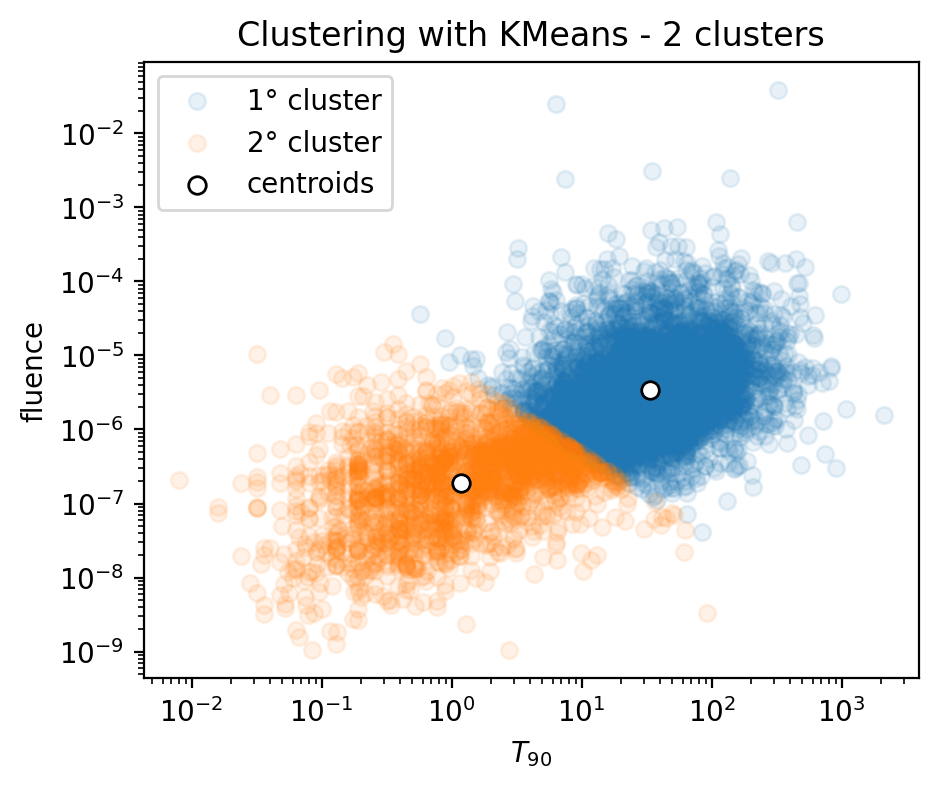

In [377]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
ax.set_title('Clustering with KMeans - 2 clusters')
ax.set_xlabel(r'$T_{90}$')
ax.set_ylabel('fluence')

for l in np.arange(len(np.unique(labels))):
    ax.scatter(np.exp(X[labels==l, 0]), np.exp(X[labels==l, 1]), alpha=0.1, label = f'{l+1}° cluster')

ax.scatter(np.exp(centers[:, 0]), np.exp(centers[:, 1]), label = 'centroids', s=40, c='w', edgecolors='k')
plt.legend()
plt.loglog()
plt.show()

[]

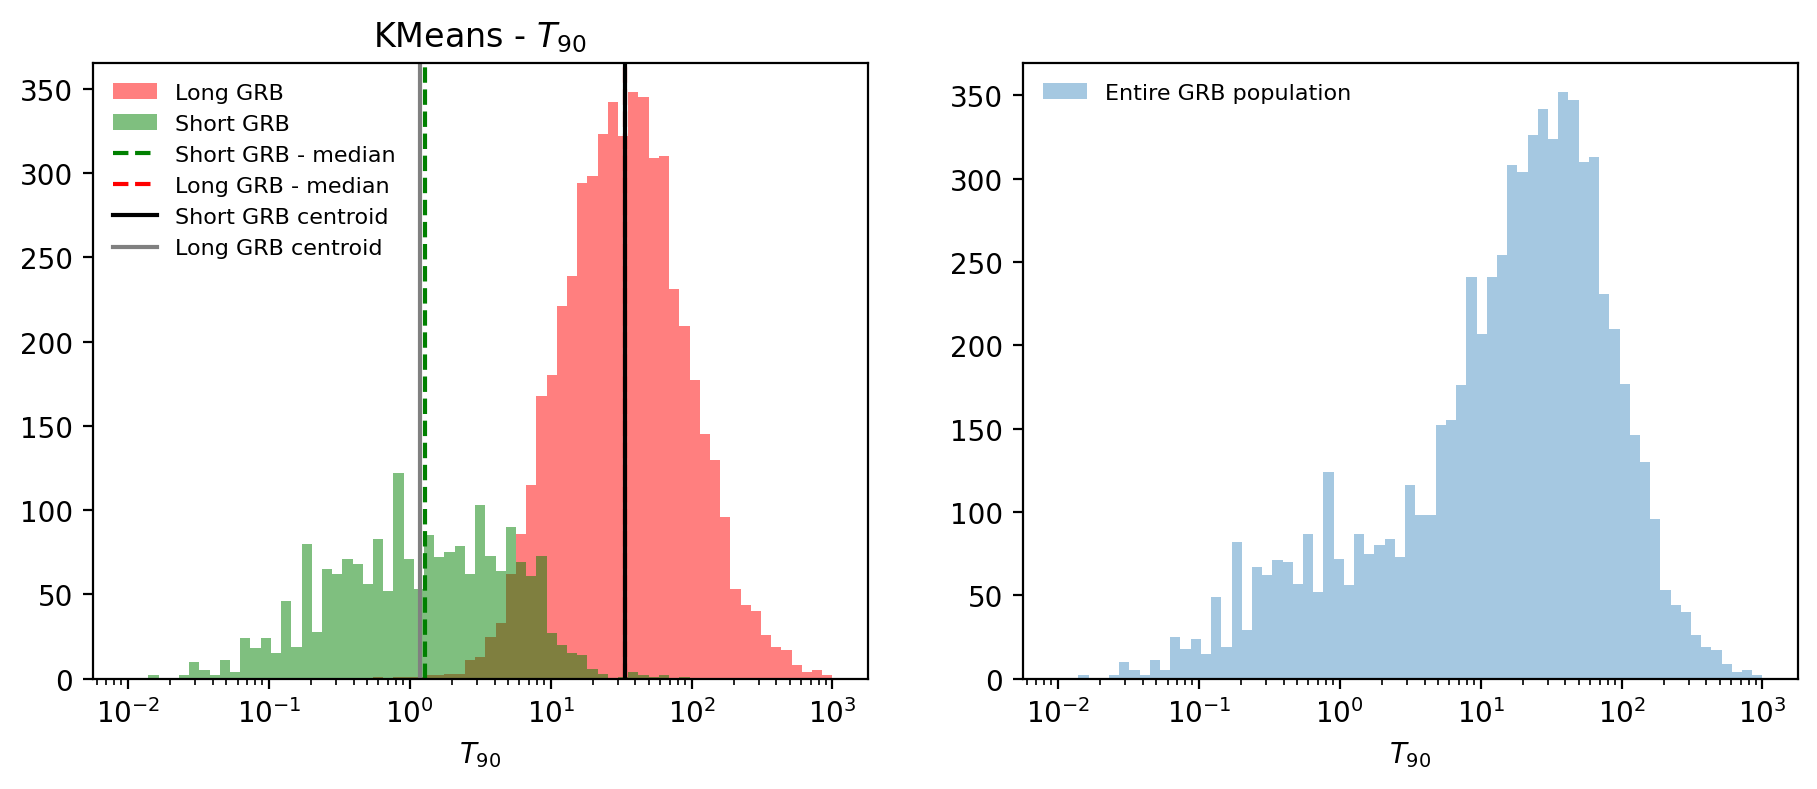

In [378]:
T90_long = np.exp(X[labels==0, 0]) #long
T90_short = np.exp(X[labels==1, 0]) #short

fig, ax = plt.subplots(1,2, figsize=(11,4))
plt.subplot(121)
plt.hist(T90_long, bins= np.logspace(-2,3,70), color='red', alpha=0.5, label='Long GRB')
plt.hist(T90_short, bins= np.logspace(-2,3,70), color='green', alpha=0.5, label='Short GRB')
plt.semilogx()
plt.axvline(np.median(T90_short), color='green', ls='--', label='Short GRB - median')
plt.axvline(np.median(T90_long), color='red', ls='--', label='Long GRB - median')
plt.axvline(np.exp(centers[0,0]), color='k', label='Short GRB centroid')
plt.axvline(np.exp(centers[1,0]), color='gray', label='Long GRB centroid')
plt.title(r'KMeans - $T_{90}$')

plt.legend(frameon=False, fontsize=8)
plt.xlabel(r'$T_{90}$')

plt.subplot(122)
plt.hist(T90, bins= np.logspace(-2,3,70), alpha=0.4, label='Entire GRB population')
plt.xlabel(r'$T_{90}$')
plt.legend(frameon=False, fontsize=8)
plt.semilogx()

[]

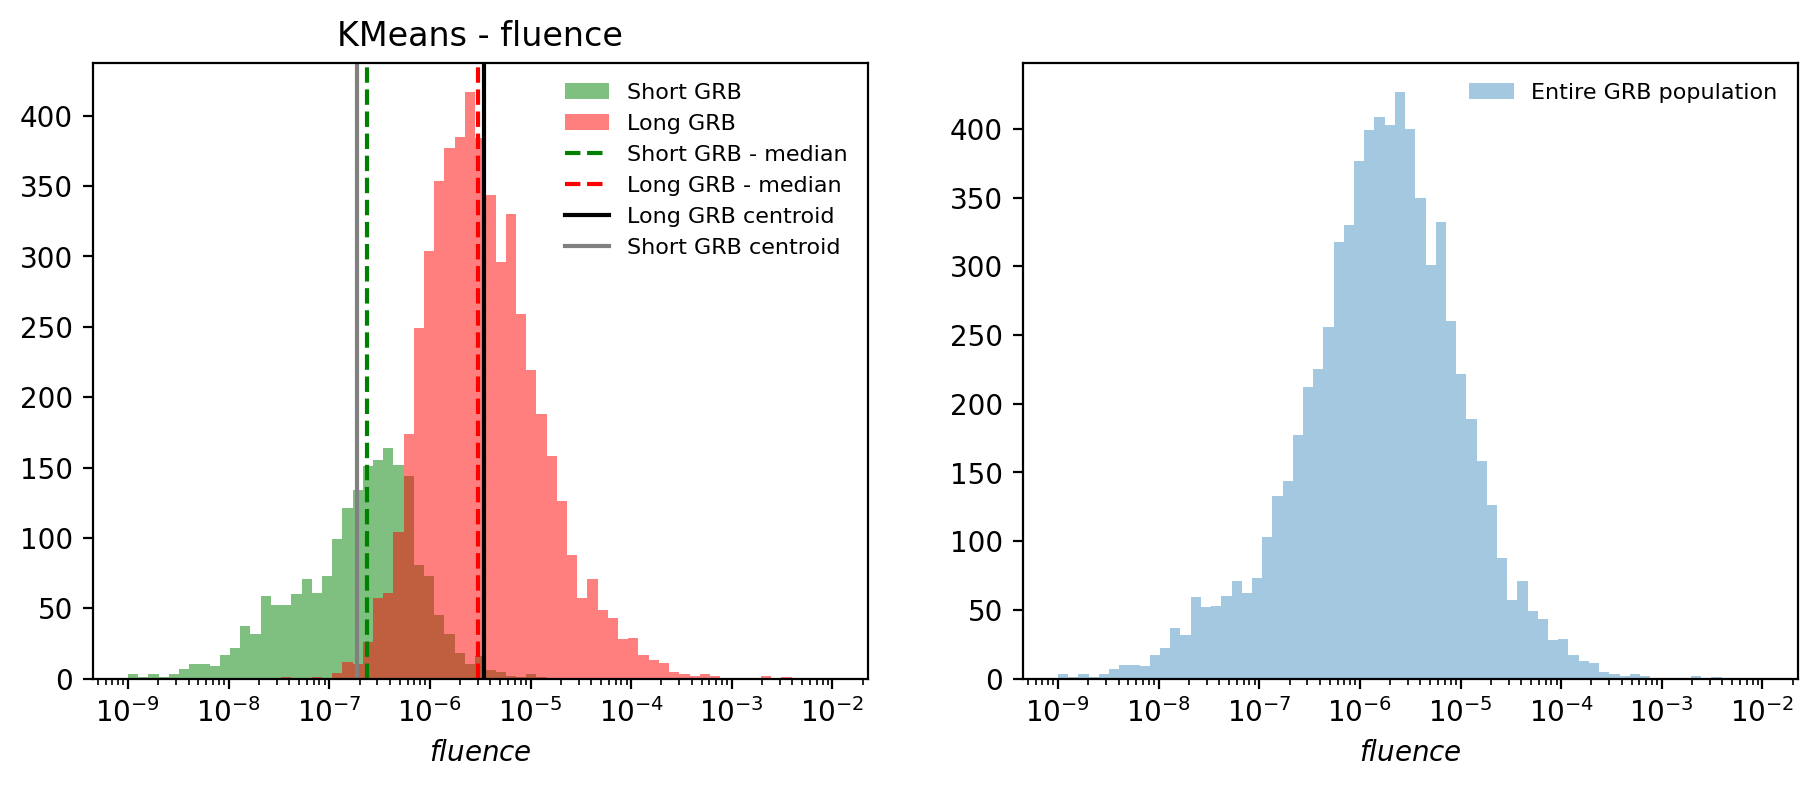

In [379]:
fluence_long = np.exp(X[labels==0, 1])
fluence_short = np.exp(X[labels==1, 1])

fig, ax = plt.subplots(1,2, figsize=(11,4))
plt.subplot(121)
plt.hist(fluence_short, bins= np.logspace(-9, -2, 70), color='green', alpha=0.5, label='Short GRB')
plt.hist(fluence_long, bins= np.logspace(-9, -2, 70), color='red', alpha=0.5, label='Long GRB')
plt.semilogx()
plt.axvline(np.median(fluence_short), color='green', ls='--', label='Short GRB - median')
plt.axvline(np.median(fluence_long), color='red', ls='--', label='Long GRB - median')
plt.axvline(np.exp(centers[0,1]), color='k', label='Long GRB centroid')
plt.axvline(np.exp(centers[1,1]), color='gray', label='Short GRB centroid')
plt.title(r'KMeans - fluence')

plt.legend(frameon=False, fontsize=8)
plt.xlabel(r'$fluence$')

plt.subplot(122)
plt.hist(fluence, bins= np.logspace(-9,-2,70), alpha=0.4, label='Entire GRB population')
plt.xlabel(r'$fluence$')
plt.legend(frameon=False, fontsize=8)
plt.semilogx()

**Comments:** 
- As we can see, we managed to separate the two populations in an unsupervised manner
- The measurement of T90 shows the bimodality more evidently

### GaussianMixture

Let'see if we can get similar results by using a different clustering algorithm such as **GaussianMixture**:

In [380]:
gm = GaussianMixture(n_components=2, covariance_type="full")
gm.fit(X)
labels_gm = gm.predict(X)

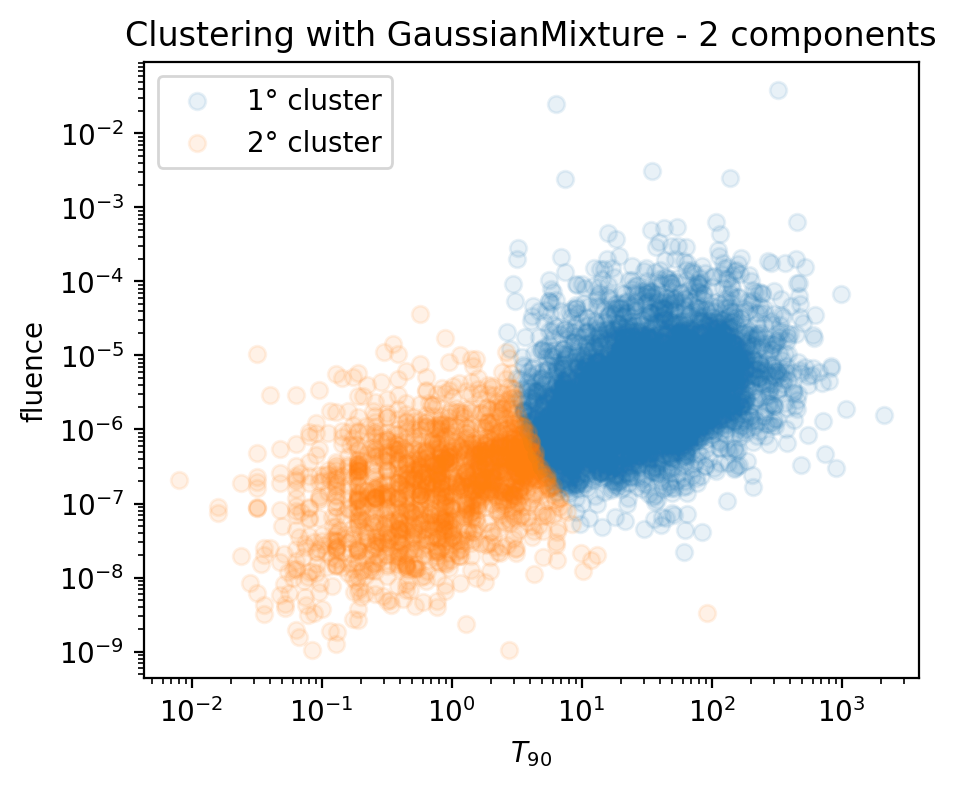

In [381]:
fig, ax = plt.subplots()
ax.set_title('Clustering with GaussianMixture - 2 components')
ax.set_xlabel(r'$T_{90}$')
ax.set_ylabel('fluence')

for l in np.arange(len(np.unique(labels_gm))):
    ax.scatter(np.exp(X[labels_gm==l, 0]), np.exp(X[labels_gm==l, 1]), alpha=0.1, label = f'{l+1}° cluster')

plt.legend()
plt.loglog()
plt.show()

[]

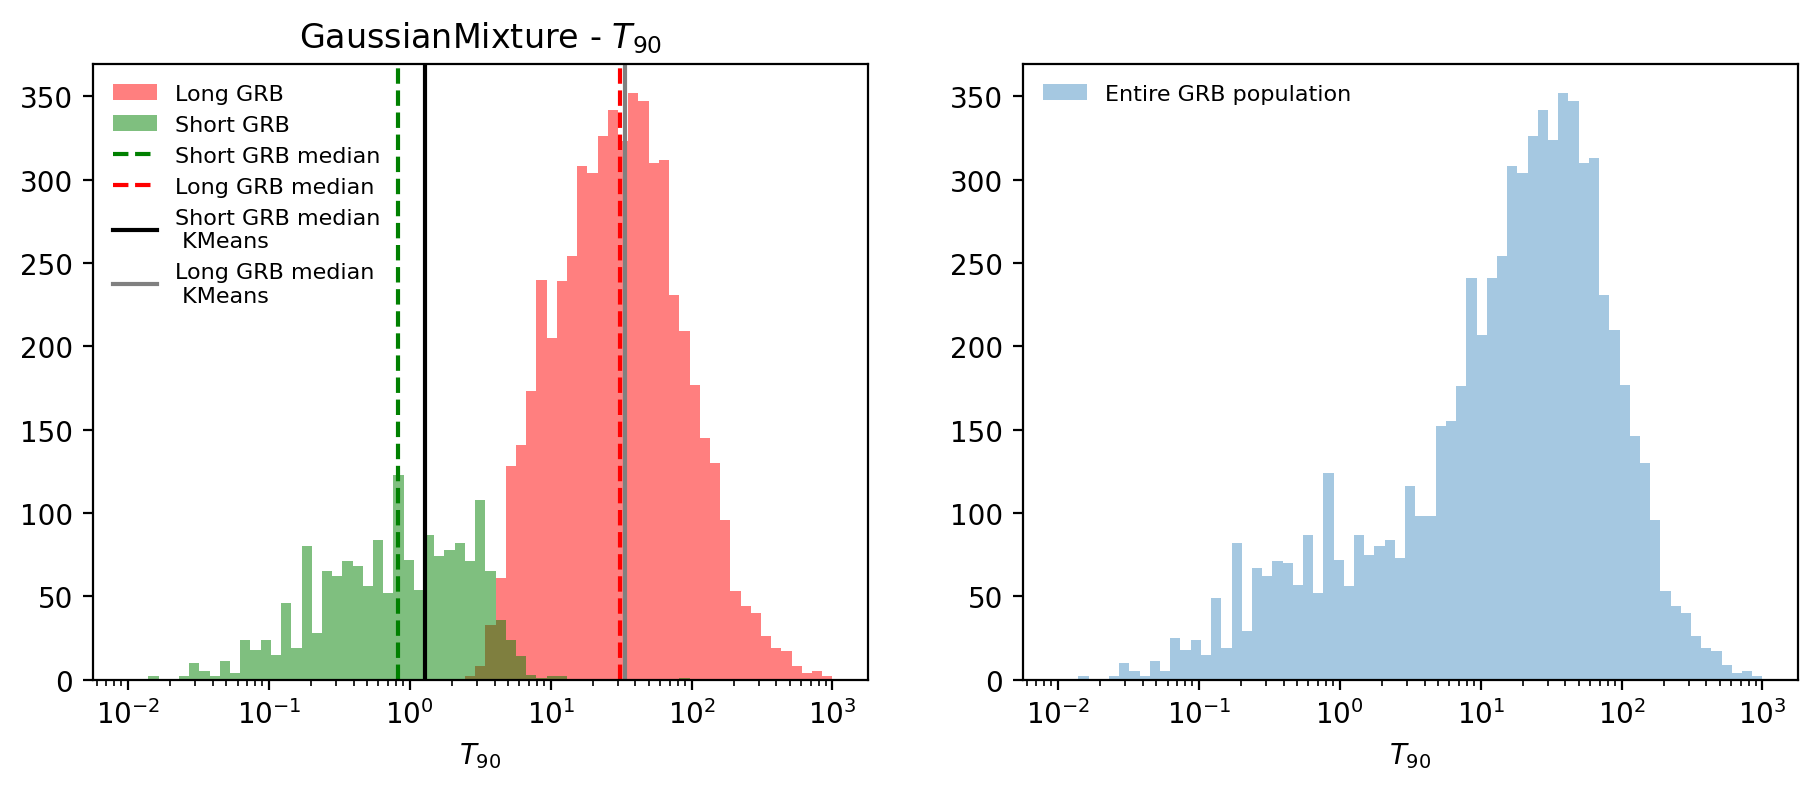

In [382]:
T90_long_gm = np.exp(X[labels_gm==0, 0]) #long
T90_short_gm = np.exp(X[labels_gm==1, 0]) #short

fig, ax = plt.subplots(1,2, figsize=(11,4))
plt.subplot(121)
plt.hist(T90_long_gm, bins= np.logspace(-2,3,70), color='red', alpha=0.5, label='Long GRB')
plt.hist(T90_short_gm, bins= np.logspace(-2,3,70), color='green', alpha=0.5, label='Short GRB')
plt.semilogx()
plt.axvline(np.median(T90_short_gm), color='green', ls='--', label='Short GRB median')
plt.axvline(np.median(T90_long_gm), color='red', ls='--', label='Long GRB median')
plt.axvline(np.median(T90_short), color='k', label='Short GRB median \n KMeans')
plt.axvline(np.median(T90_long), color='gray', label='Long GRB median \n KMeans')
plt.title(r'GaussianMixture - $T_{90}$')

plt.legend(frameon=False, fontsize=8)
plt.xlabel(r'$T_{90}$')

plt.subplot(122)
plt.hist(T90, bins= np.logspace(-2,3,70), alpha=0.4, label='Entire GRB population')
plt.xlabel(r'$T_{90}$')
plt.legend(frameon=False, fontsize=8)
plt.semilogx()

We notice that by choosing another algorithm, the median of the *Long GRB* population remains the same.
The one of the *Short GRB* population shifts towards smaller values. 

In fact, it's more difficult to identify the Short GRB cluster rather than the long one as we could have noticed even at the beginning, when we plotted the full distribution of T90. 

[]

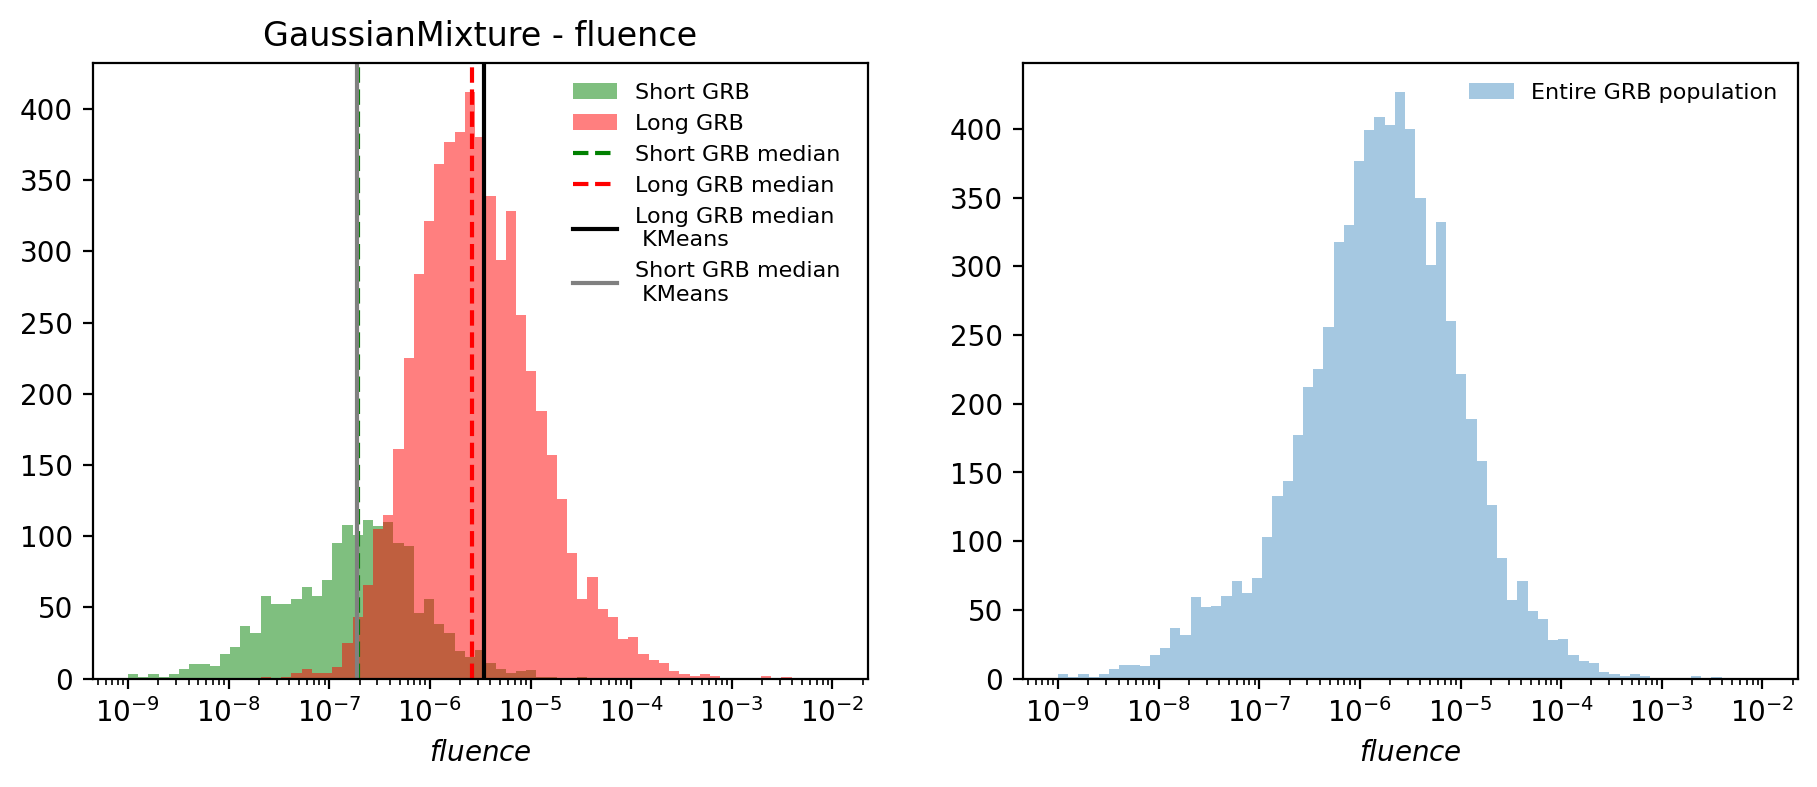

In [383]:
fluence_long_gm = np.exp(X[labels_gm==0, 1])
fluence_short_gm = np.exp(X[labels_gm==1, 1])

fig, ax = plt.subplots(1,2, figsize=(11,4))
plt.subplot(121)
plt.hist(fluence_short_gm, bins= np.logspace(-9, -2, 70), color='green', alpha=0.5, label='Short GRB')
plt.hist(fluence_long_gm, bins= np.logspace(-9, -2, 70), color='red', alpha=0.5, label='Long GRB')
plt.semilogx()
plt.axvline(np.median(fluence_short_gm), color='green', ls='--', label='Short GRB median')
plt.axvline(np.median(fluence_long_gm), color='red', ls='--', label='Long GRB median')
plt.axvline(np.exp(centers[0,1]), color='k', label='Long GRB median \n KMeans')
plt.axvline(np.exp(centers[1,1]), color='gray', label='Short GRB median \n KMeans')
plt.title(r'GaussianMixture - fluence')
plt.legend(frameon=False, fontsize=8)
plt.xlabel(r'$fluence$')

plt.subplot(122)
plt.hist(fluence, bins= np.logspace(-9,-2,70), alpha=0.4, label='Entire GRB population')
plt.xlabel(r'$fluence$')
plt.legend(frameon=False, fontsize=8)
plt.semilogx()

### Estimate of the threshold between the two population

In [386]:
gm.means_
gm.covariances_

array([[[1.09614189, 0.51470714],
        [0.51470714, 2.01336751]],

       [[2.26051171, 1.1655462 ],
        [1.1655462 , 2.78429847]]])